In [4]:
#############################################
# FEATURE ENGINEERING & DATA PRE-PROCESSING
#############################################

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

def load_application_train():
    data = pd.read_csv("application_train.csv")
    return data

df = load_application_train()
df.head()


def load():
    data = pd.read_csv("titanic.csv")
    return data


df = load()
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [5]:
#############################################
# 1. Outliers (Aykırı Değerler)
#############################################

#############################################
# Aykırı Değerleri Yakalama
#############################################

###################
# Grafik Teknikle Aykırı Değerler
###################

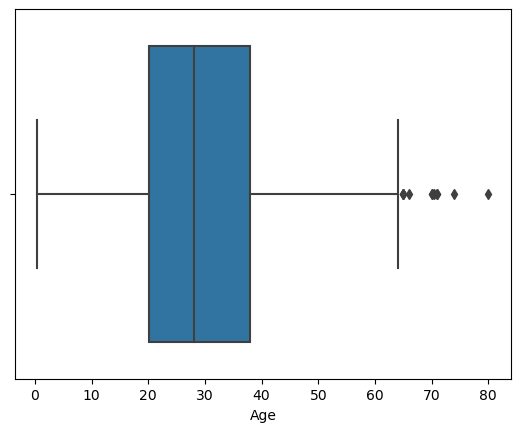

In [6]:

sns.boxplot(x=df["Age"])
plt.show()


In [7]:

###################
# Aykırı Değerler Nasıl Yakalanır?
###################

In [8]:
q1=df["Age"].quantile(0.25)
q3=df["Age"].quantile(0.75)

In [9]:
iqr=q3-q1
up=q3 + 1.5 * iqr
low = q1 - 1.5 *iqr

In [10]:
df[(df["Age"] < low) | (df["Age"] > up)]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.000,0,0,C.A. 24579,10.500,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.000,0,1,113509,61.979,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.000,0,0,PC 17754,34.654,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.500,0,0,370369,7.750,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.000,0,0,336439,7.750,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.000,0,0,13509,26.550,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.000,0,0,PC 17609,49.504,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.000,0,0,27042,30.000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.000,0,0,C.A. 24580,10.500,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.000,1,1,WE/P 5735,71.000,B22,S


In [11]:
df[(df["Age"] < low) | (df["Age"] > up)].index


Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [12]:
###################
# Aykırı Değer Var mı Yok mu?
###################

df[(df["Age"] < low) | (df["Age"] > up)].any(axis=None)
df[(df["Age"] < low)].any(axis=None)

# 1. Eşik değer belirledik.
# 2. Aykırılara eriştik.
# 3. Hızlıca aykırı değer var mı yok diye sorduk.

False

In [13]:
###################
# İşlemleri Fonksiyonlaştırmak
###################


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

outlier_thresholds(df, "Age")
outlier_thresholds(df, "Fare")

low, up = outlier_thresholds(df, "Fare")

df[(df["Fare"] < low) | (df["Fare"] > up)].head()


df[(df["Fare"] < low) | (df["Fare"] > up)].index

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

check_outlier(df, "Age")
check_outlier(df, "Fare")


True

In [14]:
###################
# grab_col_names
###################

dff = load_application_train()
dff.head()

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"]

for col in num_cols:
    print(col, check_outlier(df, col))


cat_cols, num_cols, cat_but_car = grab_col_names(dff)

num_cols = [col for col in num_cols if col not in "SK_ID_CURR"]

for col in num_cols:
    print(col, check_outlier(dff, col))

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
Age True
Fare True
Observations: 307511
Variables: 122
cat_cols: 54
num_cols: 67
cat_but_car: 1
num_but_cat: 39
CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FL

In [15]:
###################
# Aykırı Değerlerin Kendilerine Erişmek
###################

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

grab_outliers(df, "Age")

grab_outliers(df, "Age", True)

age_index = grab_outliers(df, "Age", True)


outlier_thresholds(df, "Age")
check_outlier(df, "Age")
grab_outliers(df, "Age", True)


     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q
     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 2457

Int64Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [16]:
###################
# Silme
###################

low, up = outlier_thresholds(df, "Fare")
df.shape

df[~((df["Fare"] < low) | (df["Fare"] > up))].shape



(775, 12)

In [17]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers


cat_cols, num_cols, cat_but_car = grab_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"]

df.shape

for col in num_cols:
    new_df = remove_outlier(df, col)

df.shape[0] - new_df.shape[0]

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


116

In [18]:
###################
# Baskılama Yöntemi (re-assignment with thresholds)
###################

low, up = outlier_thresholds(df, "Fare")

df[((df["Fare"] < low) | (df["Fare"] > up))]["Fare"]

df.loc[((df["Fare"] < low) | (df["Fare"] > up)), "Fare"]

df.loc[(df["Fare"] > up), "Fare"] = up

df.loc[(df["Fare"] < low), "Fare"] = low

In [20]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

df = load()
cat_cols, num_cols, cat_but_car = grab_col_names(df)
num_cols = [col for col in num_cols if col not in "PassengerId"]

df.shape

for col in num_cols:
    print(col, check_outlier(df, col))




Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4
Age True
Fare True


In [21]:
for col in num_cols:
    replace_with_thresholds(df, col)

for col in num_cols:
    print(col, check_outlier(df, col))

Age False
Fare False


carat True
depth True
table True
price True
x True
y True
z True


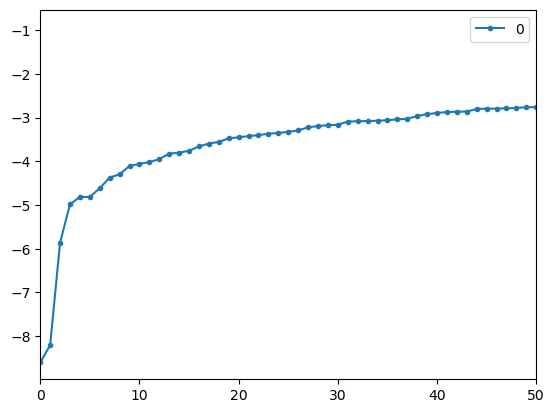

,carat,depth,table,price,x,y,z


In [22]:
#############################################
# Çok Değişkenli Aykırı Değer Analizi: Local Outlier Factor
#############################################

# 17, 3

df = sns.load_dataset('diamonds')
df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()
df.head()
df.shape
for col in df.columns:
    print(col, check_outlier(df, col))


low, up = outlier_thresholds(df, "carat")

df[((df["carat"] < low) | (df["carat"] > up))].shape

low, up = outlier_thresholds(df, "depth")

df[((df["depth"] < low) | (df["depth"] > up))].shape

clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)

df_scores = clf.negative_outlier_factor_
df_scores[0:5]
# df_scores = -df_scores
np.sort(df_scores)[0:5]

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

th = np.sort(df_scores)[3]

df[df_scores < th]

df[df_scores < th].shape


df.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T

df[df_scores < th].index

df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index)